In [1]:
# Import Libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import pingouin as pg
import seaborn as sns
import numpy as np
import seaborn as sns 
import statsmodels.api as sm 
from statsmodels.iolib.summary2 import summary_col 
from scipy.stats import pearsonr 
from sklearn.preprocessing import LabelEncoder

In [2]:
# Create a Spark Session
spark = SparkSession.builder.appName("EDA").getOrCreate()

In [3]:
# Load the Data
pandasdf = pd.read_excel('INMET_SE_SP_A771_2022.xlsx')
df = spark.createDataFrame(pandasdf)

In [4]:
# Basic Data Exploration
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,Data,timestamp
1,Hora UTC,string
2,PRECIPITAÇÃO TOTAL HORÁRIO (mm),double
3,PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARI...,double
4,PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),double
5,PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),double
6,RADIACAO GLOBAL (Kj/m²),double
7,TEMPERATURA DO AR - BULBO SECO HORARIA (°C),double
8,TEMPERATURA DO PONTO DE ORVALHO (°C),double
9,TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),double


In [5]:
# Finding the missing values

# Get the column names
column_names = df.columns

# Get the numeric_columns
numeric_columns = column_names[2:]

missing_values = {} 
for index, column in enumerate(df.columns):
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,PRECIPITAÇÃO TOTAL HORÁRIO (mm),PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB),PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),RADIACAO GLOBAL (Kj/m²),TEMPERATURA DO AR - BULBO SECO HORARIA (°C),TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),UMIDADE REL MAX NA HORA ANT (AUT) (%),UMIDADE REL MIN NA HORA ANT (AUT) (%),UMIDADE RELATIVA DO AR HORARIA (%),VENTO DIREÇÃO HORARIA (gr) (° (gr)),VENTO RAJADA MAXIMA (m/s),VENTO VELOCIDADE HORARIA (m/s)
0,7855,3,3,3,4026,3,6,4,3,3,4,3,3,6,4,3,3


In [6]:
# Remove rows with missing values
df = df.dropna()

In [7]:
# Drop the 'Hora UTC' column
df = df.drop("Hora UTC")

In [8]:
describe_result = df.describe()

# Convert the result to a Pandas DataFrame with custom column names
pandas_df_describe = describe_result.toPandas().rename(columns={'summary': 'Column Name', 'col1': 'Data type'})

# Display the Pandas DataFrame
pandas_df_describe

,Column Name,PRECIPITAÇÃO TOTAL HORÁRIO (mm),PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB),PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),RADIACAO GLOBAL (Kj/m²),TEMPERATURA DO AR - BULBO SECO HORARIA (°C),TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),UMIDADE REL MAX NA HORA ANT (AUT) (%),UMIDADE REL MIN NA HORA ANT (AUT) (%),UMIDADE RELATIVA DO AR HORARIA (%),VENTO DIREÇÃO HORARIA (gr) (° (gr)),VENTO RAJADA MAXIMA (m/s),VENTO VELOCIDADE HORARIA (m/s)
0,count,4468,4468,4468,4468,4468,4468,4468,4468,4468,4468,4468,4468,4468,4468,4468,4468,4468
1,mean,0.17555953446732322,928.0999776186212,928.3630259623992,927.8412264995524,1151.744583706356,20.529230080572958,15.456110116383169,21.219628469113697,19.725805729632945,16.323119964189793,14.640577439570272,81.33974932855864,72.41786034019695,76.58773500447627,183.05282005371532,6.097448522829006,2.3918979409131604
2,stddev,1.1602986945092744,3.696966308081455,3.6824449947338707,3.7031308361209674,1034.0481292655327,4.7302427476915,4.234704318043263,4.965400064686239,4.559781614547918,4.099272424419188,4.343697546422198,19.90658877889454,22.790462064751626,21.615597929454264,95.48046064276728,2.484539655282303,1.1241878102424863
3,min,0.0,917.5,917.5,917.0,0.0,6.8,-3.0,7.3,6.6,-1.1,-5.3,18.0,15.0,17.0,1.0,0.8,0.1
4,max,32.0,940.2,940.3,940.1,4010.7,33.6,24.4,34.7,32.8,25.2,23.7,100.0,100.0,100.0,360.0,19.8,8.0


In [9]:
# Avarage values for each month
from pyspark.sql.functions import month, year, avg

# Convert the 'Data' column to a date type if it's not already
df = df.withColumn("Data", df["Data"].cast("date"))

# Extract the month and year from the 'Data' column
df = df.withColumn("Month", month(df["Data"]))
df = df.withColumn("Year", year(df["Data"]))

# Get the numeric_columns
numeric_columns = [column for column in df.columns if column != "Data" and column != "Month" and column != "Year"]

# Create a list to store the aggregation expressions
agg_exprs = [avg(column).alias(f"Avg_{column}") for column in numeric_columns]

# Group by year and month, and calculate the average of numeric columns
grouped_df = df.groupBy("Year", "Month").agg(*agg_exprs)

# Show the resulting DataFrame
grouped_df_pd = grouped_df.toPandas()

grouped_df_pd

,Year,Month,Avg_PRECIPITAÇÃO TOTAL HORÁRIO (mm),Avg_PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB),Avg_PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),Avg_PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),Avg_RADIACAO GLOBAL (Kj/m²),Avg_TEMPERATURA DO AR - BULBO SECO HORARIA (°C),Avg_TEMPERATURA DO PONTO DE ORVALHO (°C),Avg_TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),Avg_TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),Avg_TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C),Avg_TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),Avg_UMIDADE REL MAX NA HORA ANT (AUT) (%),Avg_UMIDADE REL MIN NA HORA ANT (AUT) (%),Avg_UMIDADE RELATIVA DO AR HORARIA (%),Avg_VENTO DIREÇÃO HORARIA (gr) (° (gr)),Avg_VENTO RAJADA MAXIMA (m/s),Avg_VENTO VELOCIDADE HORARIA (m/s)
0,2022,1,0.377726,925.187703,925.410441,924.940603,1207.317401,23.404872,19.554292,24.178190,22.588399,20.449420,18.634107,86.466357,76.842227,81.658933,195.825986,5.591415,2.001624
1,2022,2,0.222340,925.941755,926.165957,925.722872,1526.504787,23.622872,18.555585,24.405053,22.732979,19.582713,17.652660,81.186170,70.885638,75.664894,170.367021,6.042287,2.406117
2,2022,3,0.331373,926.679167,926.959314,926.428431,1281.606618,24.465686,19.087990,25.297794,23.578186,20.067157,18.189461,80.375000,70.262255,75.080882,204.955882,6.084314,2.254412
3,2022,4,0.047934,928.143526,928.404959,927.907163,1217.973003,21.720937,16.879063,22.387879,20.903030,17.735262,16.041873,82.060606,72.914601,77.148760,175.435262,5.981267,2.326446
4,2022,5,0.014439,929.120053,929.400535,928.874064,1020.392781,18.747594,12.640909,19.361497,17.924599,13.501337,11.845722,76.518717,67.497326,71.478610,205.152406,6.099465,2.306952
5,2022,6,0.034409,929.977151,930.236559,929.723925,788.053763,17.605376,12.795968,18.184946,16.861828,13.570430,12.147581,82.376344,74.981183,78.107527,189.357527,5.270968,2.128495
6,2022,7,0.019074,930.795095,931.073297,930.549864,1065.247956,20.068120,11.172207,20.751771,19.123433,12.088828,10.340054,67.414169,58.427793,62.198910,197.471390,5.886921,2.277384
7,2022,8,0.036267,931.148267,931.430933,930.876800,1016.564000,17.614933,11.531467,18.239733,16.833333,12.380000,10.724800,77.680000,68.746667,72.794667,167.560000,6.639200,2.693333
8,2022,9,0.247368,929.709474,930.038158,929.402632,903.260526,16.902632,12.957368,17.494211,16.219737,13.645263,12.282105,85.789474,78.986842,82.226316,174.665789,6.521579,2.676316
9,2022,10,0.161174,927.407901,927.677878,927.119413,1102.160497,20.681038,16.650339,21.325734,19.972009,17.399323,15.927088,85.320542,77.539503,81.325056,175.880361,6.017833,2.437020


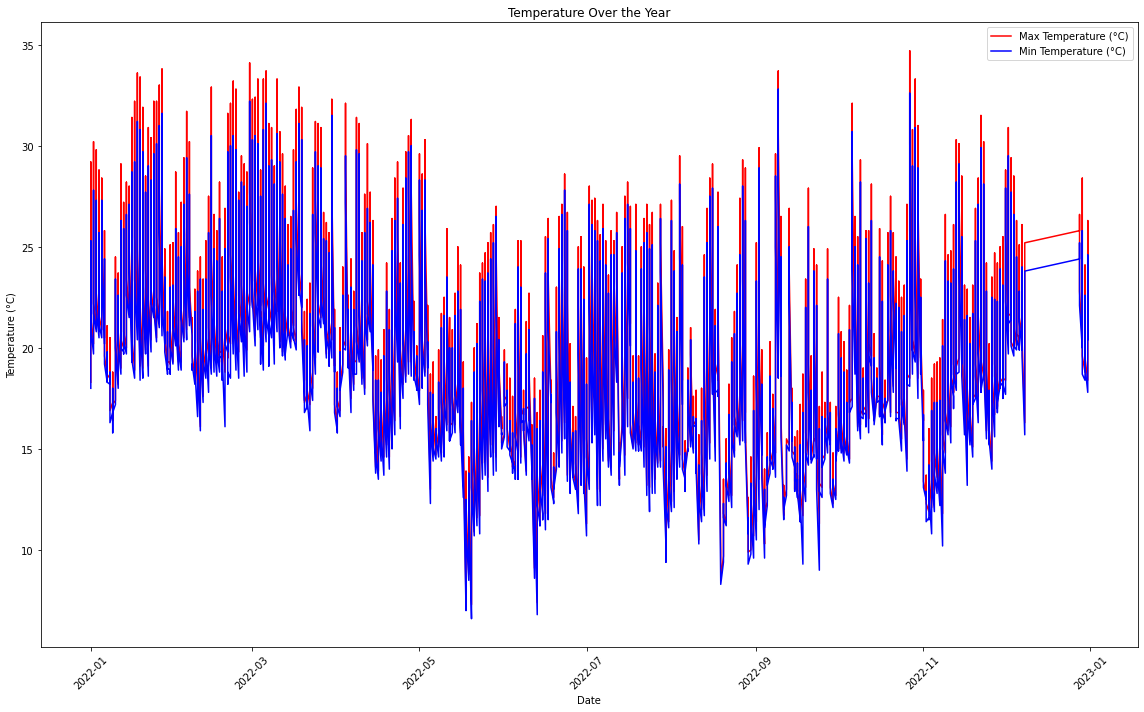

In [10]:
# Data Vizualisation: Temperature through 2022

# Select the relevant columns
temp_date_df = df.select("Data", "TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)", "TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C)")

# Convert to Pandas DataFrame
temp_date_df_pd = temp_date_df.toPandas()

# Create the chart
plt.figure(figsize=(16, 10))

plt.plot(temp_date_df_pd["Data"], temp_date_df_pd["TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)"], label="Max Temperature (°C)", color="red")
plt.plot(temp_date_df_pd["Data"], temp_date_df_pd["TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C)"], label="Min Temperature (°C)", color="blue")

plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Over the Year")
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [11]:
# Applying PCA to the dataframe filtered by the month of August

# Filter the rows where the month is 8
august_df = df.filter(month("Data") == 8)

# Show the resulting DataFrame
august_df_pd = august_df.toPandas()

august_df_pd.head()

,Data,PRECIPITAÇÃO TOTAL HORÁRIO (mm),PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB),PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),RADIACAO GLOBAL (Kj/m²),TEMPERATURA DO AR - BULBO SECO HORARIA (°C),TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),UMIDADE REL MAX NA HORA ANT (AUT) (%),UMIDADE REL MIN NA HORA ANT (AUT) (%),UMIDADE RELATIVA DO AR HORARIA (%),VENTO DIREÇÃO HORARIA (gr) (° (gr)),VENTO RAJADA MAXIMA (m/s),VENTO VELOCIDADE HORARIA (m/s),Month,Year
0,2022-08-01,0.0,929.5,929.5,929.1,0.1,12.4,12.3,12.4,11.9,12.3,11.9,100.0,100.0,100.0,17.0,4.3,1.1,8,2022
1,2022-08-01,0.0,930.0,930.0,929.5,5.0,12.3,12.3,12.4,12.3,12.4,12.3,100.0,100.0,100.0,41.0,3.7,1.2,8,2022
2,2022-08-01,0.0,930.3,930.4,930.0,135.8,12.7,12.7,12.8,12.3,12.8,12.3,100.0,100.0,100.0,5.0,3.3,1.7,8,2022
3,2022-08-01,0.0,930.5,930.5,930.3,488.0,14.0,14.0,14.0,12.7,14.0,12.7,100.0,100.0,100.0,359.0,4.3,1.5,8,2022
4,2022-08-01,0.0,930.7,930.7,930.5,1631.1,16.9,13.2,17.0,14.0,14.4,12.9,100.0,79.0,79.0,44.0,4.3,1.8,8,2022


In [12]:
# Get the number of rows
num_rows = august_df.count()

# Get the list of column names
column_names = august_df.columns

# Display the dimensions
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {len(column_names)}")

Number of Rows: 375
Number of Columns: 20


In [13]:
column_names

['Data',
 'PRECIPITAÇÃO TOTAL HORÁRIO (mm)',
 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)',
 'PRESSÃO ATMOSFERICA MAX NA HORA ANT  (AUT) (mB)',
 'PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB)',
 'RADIACAO GLOBAL (Kj/m²)',
 'TEMPERATURA DO AR - BULBO SECO HORARIA (°C)',
 'TEMPERATURA DO PONTO DE ORVALHO (°C)',
 'TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)',
 'TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C)',
 'TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C)',
 'TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C)',
 'UMIDADE REL MAX NA HORA ANT (AUT) (%)',
 'UMIDADE REL MIN NA HORA ANT (AUT) (%)',
 'UMIDADE RELATIVA DO AR HORARIA (%)',
 'VENTO DIREÇÃO HORARIA (gr) (° (gr))',
 'VENTO RAJADA MAXIMA (m/s)',
 'VENTO VELOCIDADE HORARIA (m/s)',
 'Month',
 'Year']

In [14]:
# List the columns you want to calculate the averages for
columns_to_average = [
    ('PRESSÃO ATMOSFERICA MAX NA HORA ANT  (AUT) (mB)', 'PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB)'),
    ('TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)', 'TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C)'),
    ('TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C)', 'TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C)'),
    ('UMIDADE REL MAX NA HORA ANT (AUT) (%)', 'UMIDADE REL MIN NA HORA ANT (AUT) (%)'),
    ('VENTO RAJADA MAXIMA (m/s)', 'VENTO VELOCIDADE HORARIA (m/s)')
]

# Create a new DataFrame to store the averages
aug_avg_df_pd = pd.DataFrame()

# Calculate and store the averages for each column pair
for col1, col2 in columns_to_average:
    average_col_name = f'AVERAGE_{col1}_{col2}'  # Create a new column name
    aug_avg_df_pd[average_col_name] = (august_df_pd[col1] + august_df_pd[col2]) / 2

# Select the columns you want to keep from the original DataFrame
columns_to_keep = ['PRECIPITAÇÃO TOTAL HORÁRIO (mm)',
                   'RADIACAO GLOBAL (Kj/m²)']

# Select those columns from the original DataFrame
selected_columns = august_df_pd[columns_to_keep]

# Concatenate the selected columns with the DataFrame containing averages
aug_df_pd = pd.concat([selected_columns, aug_avg_df_pd], axis=1)

# Show de df
aug_df_pd.head()

,PRECIPITAÇÃO TOTAL HORÁRIO (mm),RADIACAO GLOBAL (Kj/m²),AVERAGE_PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB)_PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),AVERAGE_TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)_TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),AVERAGE_TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C)_TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),AVERAGE_UMIDADE REL MAX NA HORA ANT (AUT) (%)_UMIDADE REL MIN NA HORA ANT (AUT) (%),AVERAGE_VENTO RAJADA MAXIMA (m/s)_VENTO VELOCIDADE HORARIA (m/s)
0,0.0,0.1,929.30,12.15,12.10,100.0,2.70
1,0.0,5.0,929.75,12.35,12.35,100.0,2.45
2,0.0,135.8,930.20,12.55,12.55,100.0,2.50
3,0.0,488.0,930.40,13.35,13.35,100.0,2.90
4,0.0,1631.1,930.60,15.50,13.65,89.5,3.05


C:\Users\digui\AppData\Local\Temp\ipykernel_18168\2245855657.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


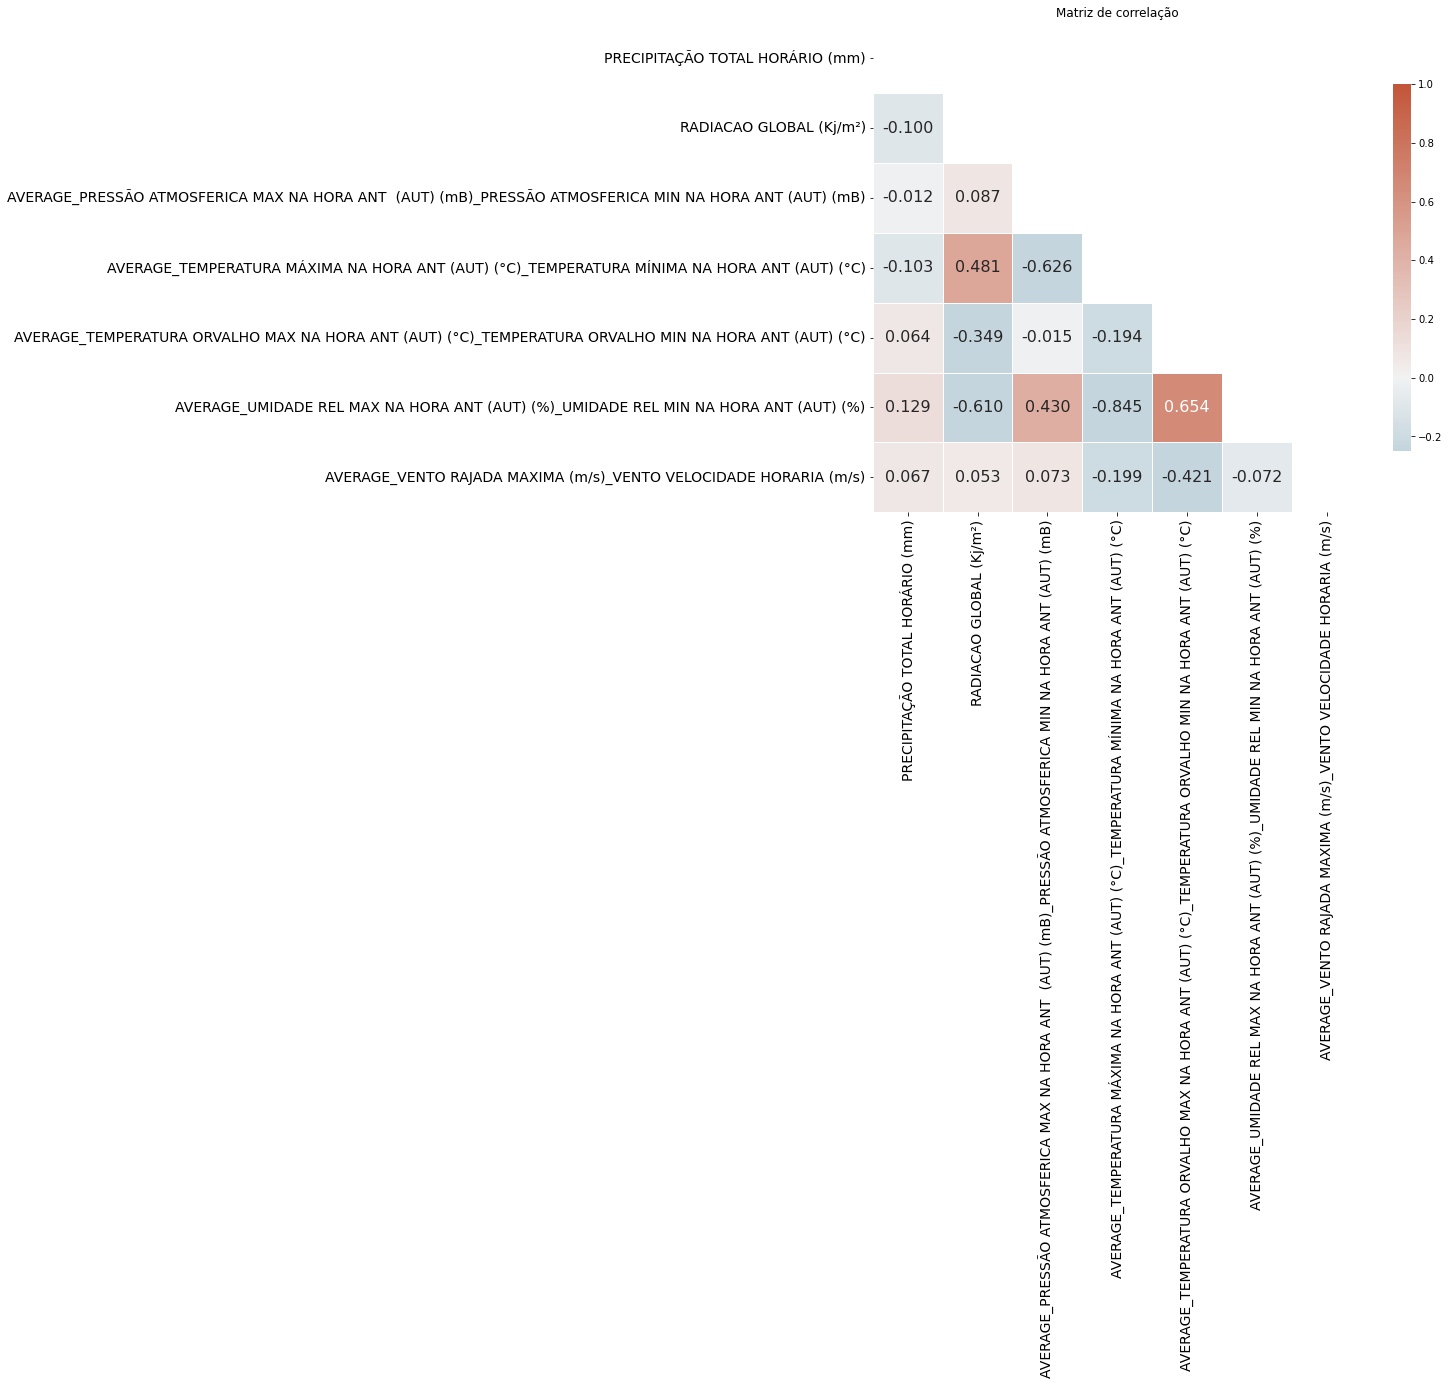

In [15]:
# Another way to plot the same information

corr = aug_df_pd.corr()

f, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, n=256, as_cmap=True)

sns.heatmap(aug_df_pd.corr(), 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            vmin = -.25,
            center=0,
            square=True, 
            linewidths=.5,
            annot = True,
            fmt='.3f', 
            annot_kws={'size': 16},
            cbar_kws={"shrink": .75})

plt.title('Matriz de correlação')
plt.tight_layout()
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_ylim(len(corr))

plt.show()

In [16]:
# Your original column names
original_columns = ['PRECIPITAÇÃO TOTAL HORÁRIO (mm)',
                    'RADIACAO GLOBAL (Kj/m²)',
                    'AVERAGE_PRESSÃO ATMOSFERICA MAX NA HORA ANT  (AUT) (mB)_PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB)',
                    'AVERAGE_TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)_TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C)',
                    'AVERAGE_TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C)_TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C)',
                    'AVERAGE_UMIDADE REL MAX NA HORA ANT (AUT) (%)_UMIDADE REL MIN NA HORA ANT (AUT) (%)',
                    'AVERAGE_VENTO RAJADA MAXIMA (m/s)_VENTO VELOCIDADE HORARIA (m/s)']

# Simplify the column names
simplified_columns = [
    'Precipitation',
    'Global_Radiation',
    'Avarage_Atmospheric_Pressure',
    'Avarage_Temperature',
    'Avarage_Dew_Temperature',
    'Avarage_Relative_Humidity',
    'Avarage_Wind_Speed'
]

# Rename the columns in the DataFrame
aug_df_pd.columns = simplified_columns

In [17]:
# Estimating a linear multiple model with all variables
model_lrm = sm.OLS.from_formula("Avarage_Temperature ~ Precipitation +\
                                Global_Radiation +\
                                Avarage_Atmospheric_Pressure +\
                                Avarage_Dew_Temperature +\
                                Avarage_Relative_Humidity +\
                                Avarage_Wind_Speed", aug_df_pd).fit()

# Get the R² 
lrm_R2 = model_lrm.rsquared

# Model parameters
model_lrm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Avarage_Temperature   R-squared:                       0.950
Model:                             OLS   Adj. R-squared:                  0.950
Method:                  Least Squares   F-statistic:                     1177.
Date:                 Mon, 18 Sep 2023   Prob (F-statistic):          1.13e-236
Time:                         00:29:38   Log-Likelihood:                -559.76
No. Observations:                  375   AIC:                             1134.
Df Residuals:                      368   BIC:                             1161.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      127.1026     19.158      6.634      0.000      89.430     164.775
Precipitation                    0.2259      0.200      1.128      0.260      -0.168       0.620
Global_Radiation                -0.0003      0.000     -2.498      0.013      -0.000   -5.41e-05
Avarage_Atmospheric_Pressure    -0.1076      0.021     -5.188      0.000      -0.148      -0.067
Avarage_Dew_Temperature          0.8171      0.032     25.771      0.000       0.755       0.879
Avarage_Relative_Humidity       -0.2465      0.006    -40.919      0.000      -0.258      -0.235
Avarage_Wind_Speed              -0.1073      0.034     -3.173      0.002      -0.174      -0.041
==============================================================================
Omnibus:                       41.461   Durbin-Watson:                   0.427
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.902
Skew:                           0.594   Prob(JB):                     4.96e-20
Kurtosis:                       5.069   Cond. No.                     5.28e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# Estimating a new multiple model with dependent variable transformed by Box-Cox

# Stepwise Procedure

# Installation and loading of the package's 'stepwise' function
#'statstests.process'
# Package authors: Helder Prado Santos and Luiz Paulo Fávero
# https://stats-tests.github.io/statstests/
# pip install statstests
from statstests.process import stepwise

# Model estimation using the Stepwise procedure
model_setpwise = stepwise(model_lrm, pvalue_limit=0.05)

# Get the R²
stepwise_R2 = model_setpwise.rsquared

Regression type: OLS 

Estimating model...: 
 Avarage_Temperature ~ Q('Precipitation') + Q('Global_Radiation') + Q('Avarage_Atmospheric_Pressure') + Q('Avarage_Dew_Temperature') + Q('Avarage_Relative_Humidity') + Q('Avarage_Wind_Speed')

 Discarding atribute "Q('Precipitation')" with p-value equal to 0.2601333649746221 

Estimating model...: 
 Avarage_Temperature ~ Q('Global_Radiation') + Q('Avarage_Atmospheric_Pressure') + Q('Avarage_Dew_Temperature') + Q('Avarage_Relative_Humidity') + Q('Avarage_Wind_Speed')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('Precipitation')", 'p-value': 0.2601333649746221}

 Model after stepwise process...: 
 Avarage_Temperature ~ Q('Global_Radiation') + Q('Avarage_Atmospheric_Pressure') + Q('Avarage_Dew_Temperature') + Q('Avarage_Relative_Humidity') + Q('Avarage_Wind_Speed') 

                             OLS Regression Results                            
Dep. Variable:     Avarage_Temperatu

In [19]:
# Test to verify the adherence of waste to normality

# Shapiro-Wilk test (n < 30)
# from scipy.stats import shapiro
# shapiro(modelo_step_empresas.resid)

# Shapiro-Francia test (n >= 30)
# Installation and loading of the package 'shapiro_francia' function
#'statstests.tests'
# Package authors: Luiz Paulo Fávero and Helder Prado Santos
# https://stats-tests.github.io/statstests/
# pip install statstests
from statstests.tests import shapiro_francia
shapiro_francia(model_setpwise.resid)

# Interpretation
teste_sf = shapiro_francia(model_setpwise.resid) # creation of the 'teste_sf' object
teste_sf = teste_sf.items() # returns the group of key-value pairs in the dictionary
method, statistics_W, statistics_z, p = teste_sf # definition of list elements (tuple)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 # level of significance
if p[1] > alpha:
	print('H0 is not rejected - Distribution in line with normality')
else:
	print('H0 is rejected - Distribution not adhering to normality')


method  :  Shapiro-Francia normality test
statistics W  :  0.964425560088996
statistics z  :  4.95292049526154
p-value  :  3.655392519831773e-07
method  :  Shapiro-Francia normality test
statistics W  :  0.964425560088996
statistics z  :  4.95292049526154
p-value  :  3.655392519831773e-07
Statistics W=0.96443, p-value=0.000000
H0 is rejected - Distribution not adhering to normality


In [20]:
# For the Box-Cox lambda calculation
from scipy.stats import boxcox

x, lmbda = boxcox(aug_df_pd['Avarage_Temperature'])
print("Lambda: ",lmbda)

# Copy the original DataFrame to a new one
new_df = aug_df_pd.copy()

# Inserting the Box-Cox lambda into the dataset to estimate a new model
new_df['bc_Avarage_Temperature'] = x

# Estimating a new multiple model with dependent variable transformed by Box-Cox
model_boxcox = sm.OLS.from_formula("bc_Avarage_Temperature ~ Precipitation +\
                                Global_Radiation +\
                                Avarage_Atmospheric_Pressure +\
                                Avarage_Dew_Temperature +\
                                Avarage_Relative_Humidity +\
                                Avarage_Wind_Speed", new_df).fit()

# Model parameters
model_boxcox.summary()

# Get the R²
model_boxcox_R2 = model_boxcox.rsquared

Lambda:  0.23836401490243705


In [21]:
# Applying the Stepwise procedure to 'model_boxcox"
model_step_boxcox = stepwise(model_boxcox, pvalue_limit=0.05)

# Get the R²
model_step_boxcox_R2 = model_step_boxcox.rsquared

# Checking the normality of the residuals of 'model_step_boxcox'

# Shapiro-Francia test
shapiro_francia(model_step_boxcox.resid)

# Interpretation
teste_sf = shapiro_francia(model_step_boxcox.resid) # creation of the 'teste_sf' object
teste_sf = teste_sf.items() # returns the group of key-value pairs in the dictionary
method, statistics_W, statistics_z, p = teste_sf # definition of list elements (tuple)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 # level of significance
if p[1] > alpha:
	print('H0 is not rejected - Distribution in line with normality')
else:
	print('H0 is rejected - Distribution not adhering to normality')


Regression type: OLS 

Estimating model...: 
 bc_Avarage_Temperature ~ Q('Precipitation') + Q('Global_Radiation') + Q('Avarage_Atmospheric_Pressure') + Q('Avarage_Dew_Temperature') + Q('Avarage_Relative_Humidity') + Q('Avarage_Wind_Speed')

 Discarding atribute "Q('Global_Radiation')" with p-value equal to 0.7983630447207106 

Estimating model...: 
 bc_Avarage_Temperature ~ Q('Precipitation') + Q('Avarage_Atmospheric_Pressure') + Q('Avarage_Dew_Temperature') + Q('Avarage_Relative_Humidity') + Q('Avarage_Wind_Speed')

 Discarding atribute "Q('Precipitation')" with p-value equal to 0.46837864282051456 

Estimating model...: 
 bc_Avarage_Temperature ~ Q('Avarage_Atmospheric_Pressure') + Q('Avarage_Dew_Temperature') + Q('Avarage_Relative_Humidity') + Q('Avarage_Wind_Speed')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('Global_Radiation')", 'p-value': 0.7983630447207106}
{'atribute': "Q('Precipitation')", 'p-value': 0.468378642

In [22]:
# Create a DataFrame
R2_data = {
    "Model": ["Linear Regression", "Stepwise Regression", "BoxCox", "Stepwise Boxcox"],
    "R-squared": [lrm_R2, stepwise_R2, model_boxcox_R2, model_step_boxcox_R2]
}

R2_df = pd.DataFrame(R2_data)
R2_df

,Model,R-squared
0,Linear Regression,0.950467
1,Stepwise Regression,0.950295
2,BoxCox,0.968649
3,Stepwise Boxcox,0.968598
